## **MixUp**

Il mixup è una tecnica di data augmentation utilizzata durante l'addestramento delle reti neurali. L'idea fondamentale è quella di creare nuovi esempi di training mescolando coppie di esempi esistenti nel dataset.

### 1. **Scelta degli Esempi da Mescolare**
Si selezionano casualmente due esempi dal dataset di training. Questi possono essere immagini, testi, o qualsiasi altro tipo di dati. Chiamiamo questi esempi $ x_1 $ e $ x_2 $, e le loro corrispondenti etichette (o target) $ y_1 $ e $ y_2 $.

### 2. **Generazione del Coefficiente di Mixup**
Si genera un coefficiente, chiamato $ \lambda $, che determina quanto ogni esempio contribuirà al nuovo esempio sintetico. Questo valore è in genere estratto da una distribuzione Beta, $ \text{Beta}(\alpha, \alpha) $, dove $ \alpha $ è un iperparametro che controlla la forma della distribuzione. Valori comuni per $ \alpha $ sono 0.1, 0.2, o 0.4.

### 3. **Combinazione degli Input**
I due input selezionati vengono combinati usando il coefficiente $ \lambda $ per formare un nuovo input $ \tilde{x} $. La formula è:
$$ \tilde{x} = \lambda x_1 + (1 - \lambda) x_2 $$
Questo significa che il nuovo input è una combinazione lineare dei due input originali.

### 4. **Combinazione delle Etichette**
Analogamente agli input, anche le etichette vengono combinate usando lo stesso coefficiente $ \lambda $. Se le etichette sono rappresentate come vettori (come nel caso di classificazione con più classi), la combinazione è:
$$ \tilde{y} = \lambda y_1 + (1 - \lambda) y_2 $$
Questa operazione crea un'etichetta "mista" che rappresenta la combinazione delle etichette originali.

### 5. **Addestramento con Dati Mixup**
Il modello viene poi addestrato usando il nuovo insieme di esempi di input $ \tilde{x} $ e le corrispondenti etichette miste $ \tilde{y} $. Durante l'addestramento, il modello impara a generalizzare tra gli esempi, anziché memorizzare caratteristiche specifiche di ciascun esempio.

### Focus su distribuzione Beta

[Applet interattiva](https://homepage.stat.uiowa.edu/~mbognar/applets/beta.html)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/1280px-Beta_distribution_pdf.svg.png" width=500 />

#### 1. **Generazione del Coefficiente di Mixup ($\lambda$)**
La chiave del mixup è la generazione di un coefficiente, $\lambda$, che determina come combinare due esempi di training. Questo coefficiente è generato casualmente per ogni coppia di esempi, e la distribuzione Beta è utilizzata per questo scopo. 

#### 2. **La Distribuzione Beta**
La distribuzione Beta, parametrizzata da $\alpha$ e $\beta$, è una distribuzione di probabilità continua definita sull'intervallo [0, 1]. Nel contesto del mixup, i parametri $\alpha$ e $\beta$ sono spesso impostati allo stesso valore, creando una distribuzione simmetrica. Questo valore comune è un iperparametro del processo di mixup.

#### 3. **Impatto dei Parametri $\alpha$ e $\beta$**
- **$\alpha = \beta = 1$**: Questo caso speciale rende la distribuzione Beta una distribuzione uniforme. Il coefficiente $\lambda$ avrà una probabilità uguale di assumere qualsiasi valore tra 0 e 1.
- **$\alpha, \beta > 1$**: La distribuzione tende a concentrarsi intorno a 0.5, incoraggiando un mix più equilibrato degli esempi.
- **$\alpha, \beta < 1$**: La distribuzione tende a favorire valori vicino a 0 o 1, portando a combinazioni meno equilibrate, dove uno degli esempi ha un peso maggiore.

#### 4. **Calcolo di $\lambda$**
Per ogni coppia di esempi di training, un valore di $\lambda$ è estratto dalla distribuzione Beta($\alpha, \beta$). Questo valore determina il peso di ciascun esempio nella combinazione.


### Sitografia

https://www.tensorflow.org/api_docs/python/tfm/vision/augment/MixupAndCutmix

https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



import gc

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

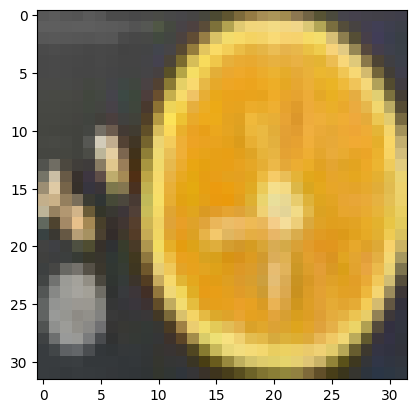

In [3]:
x_train.shape

plt.imshow(x_test[19])
plt.show()

In [4]:
x_train = x_train / 255.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

x_test = x_test / 255.
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [5]:
new_x_train = []
new_y_train = []

for _ in range(10):
    idx = np.random.permutation(len(x_train))
    idx_2 = np.random.permutation(len(x_train))
    
    for i in range(len(x_train)):    
        l = np.random.random() * .15 + .1
        new_x_train.append((x_train[idx[i]] * l) + (x_train[idx_2[i]] * (1 - l)))
        new_y_train.append((y_train[idx[i]] * l) + (y_train[idx_2[i]] * (1 - l)))
        
    print('*', end='')

**********

In [6]:
new_x_train = np.asarray(new_x_train, dtype=np.float32)
new_y_train = np.asarray(new_y_train, dtype=np.float32)

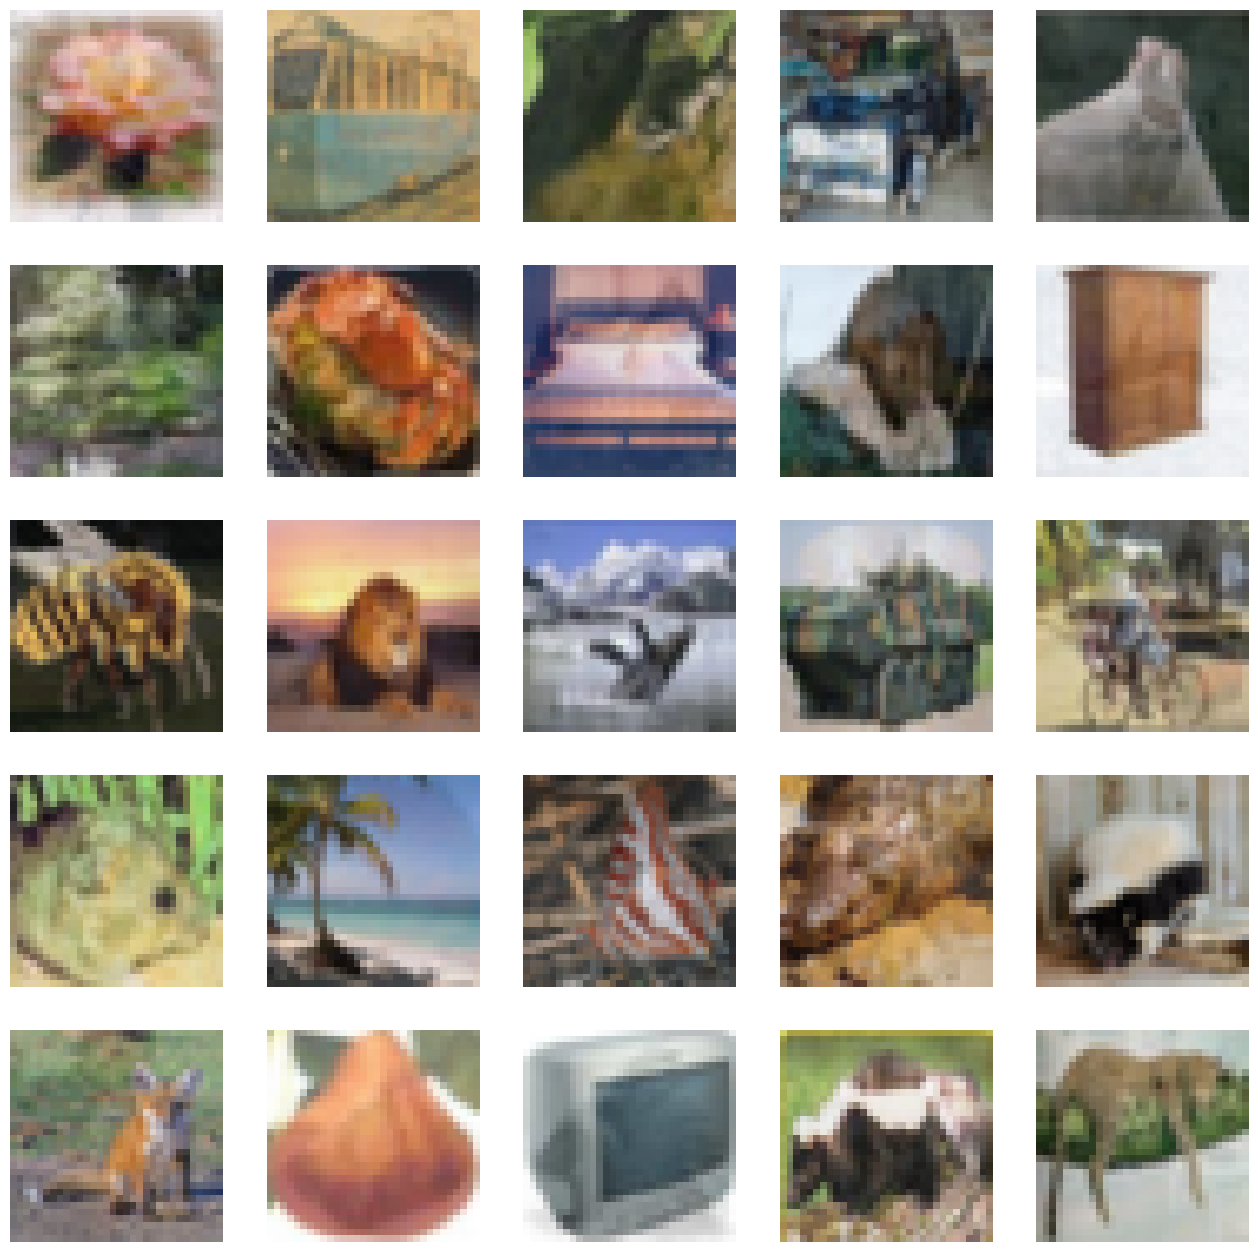

In [7]:
plt.figure(figsize=(16, 16))
for i, (image, label) in enumerate(zip(new_x_train[5:30], new_y_train[5:30])):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.axis("off")

In [8]:
def get_model():
    input_layer = tf.keras.layers.Input(shape=(32, 32, 3))
    
    conv_1 = tf.keras.layers.Conv2D(32, 3, activation="swish")(input_layer)
    conv_1 = tf.keras.layers.Dropout(.25)(conv_1)
    conv_1 = tf.keras.layers.Conv2D(64, 3, activation="swish")(conv_1)
    conv_1 = tf.keras.layers.Dropout(.25)(conv_1)
    conv_1 = tf.keras.layers.MaxPool2D()(conv_1)
    conv_1 = tf.keras.layers.BatchNormalization()(conv_1)
    
    conv_2 = tf.keras.layers.Conv2D(128, 3, activation="swish")(conv_1)
    conv_2 = tf.keras.layers.Dropout(.33)(conv_2)
    conv_2 = tf.keras.layers.Conv2D(256, 3, activation="swish")(conv_2)
    conv_2 = tf.keras.layers.Dropout(.33)(conv_2)
    conv_2 = tf.keras.layers.MaxPool2D()(conv_2)
    conv_2 = tf.keras.layers.BatchNormalization()(conv_2)
    
    dense = tf.keras.layers.Flatten()(conv_2)
    
    dense = tf.keras.layers.Dense(256, activation="swish")(dense)
    dense = tf.keras.layers.Dropout(.5)(dense)
    dense = tf.keras.layers.Dense(256, activation="swish")(dense)
    dense = tf.keras.layers.Dropout(.5)(dense)
    
    output_layer = tf.keras.layers.Dense(100, activation="softmax")(dense)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=tf.keras.metrics.TopKCategoricalAccuracy(k=10),
        optimizer=tf.keras.optimizers.Adam()
    )
    
    model.summary()
    
    return model

In [9]:
model_norm = get_model()
model_mixup = get_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                             

2024-01-08 19:48:26.174240: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 19:48:26.227312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-08 19:48:26.227549: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 dropout_6 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 dropout_7 (Dropout)         (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                           

In [10]:
history_norm = model_norm.fit(x_train[2000:], y_train[2000:], epochs=50, batch_size=256, validation_data=(x_train[:2000], y_train[:2000]), verbose=2)

Epoch 1/50


2024-01-08 19:48:27.884847: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-08 19:48:28.019595: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-01-08 19:48:29.430569: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 604.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-08 19:48:29.544136: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 604.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were availab

188/188 - 15s - loss: 4.5993 - top_k_categorical_accuracy: 0.2192 - val_loss: 4.6126 - val_top_k_categorical_accuracy: 0.0895 - 15s/epoch - 82ms/step
Epoch 2/50
188/188 - 6s - loss: 4.1431 - top_k_categorical_accuracy: 0.3683 - val_loss: 4.9503 - val_top_k_categorical_accuracy: 0.1225 - 6s/epoch - 34ms/step
Epoch 3/50
188/188 - 6s - loss: 3.8522 - top_k_categorical_accuracy: 0.4681 - val_loss: 4.7064 - val_top_k_categorical_accuracy: 0.2195 - 6s/epoch - 33ms/step
Epoch 4/50
188/188 - 6s - loss: 3.5770 - top_k_categorical_accuracy: 0.5556 - val_loss: 3.9850 - val_top_k_categorical_accuracy: 0.4110 - 6s/epoch - 34ms/step
Epoch 5/50
188/188 - 6s - loss: 3.3331 - top_k_categorical_accuracy: 0.6171 - val_loss: 3.4956 - val_top_k_categorical_accuracy: 0.5510 - 6s/epoch - 34ms/step
Epoch 6/50
188/188 - 6s - loss: 3.1167 - top_k_categorical_accuracy: 0.6692 - val_loss: 3.4881 - val_top_k_categorical_accuracy: 0.5690 - 6s/epoch - 34ms/step
Epoch 7/50
188/188 - 6s - loss: 2.9270 - top_k_categori

In [15]:
history_mixup = model_mixup.fit(new_x_train[2000:], new_y_train[2000:], epochs=5, batch_size=256, validation_data=(new_x_train[:2000], new_y_train[:2000]), verbose=2)






2024-01-08 20:12:56.828842: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6119424000 exceeds 10% of free system memory.
2024-01-08 20:13:11.346063: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.70GiB (rounded to 6119424000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-08 20:13:11.346137: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-01-08 20:13:11.346167: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 70, Chunks in use: 70. 17.5KiB allocated for chunks. 17.5KiB in use in bin. 4.7KiB client-requested in use in bin.
2024-01-08 20:13:11.346187: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

 256 next 92
2024-01-08 20:13:11.347285: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5362004d00 of size 256 next 93
2024-01-08 20:13:11.347300: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5362004e00 of size 256 next 94
2024-01-08 20:13:11.347316: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5362004f00 of size 256 next 95
2024-01-08 20:13:11.347331: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5362005000 of size 512 next 97
2024-01-08 20:13:11.347346: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5362005200 of size 512 next 98
2024-01-08 20:13:11.347362: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5362005400 of size 1024 next 100
2024-01-08 20:13:11.347379: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f5362005800 of size 1024 next 101
2024-01-08 20:13:11.347395: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] I

In [13]:
norm_res = model_norm.evaluate(x_test, y_test, batch_size=256)
mixup_res = model_mixup.evaluate(x_test, y_test, batch_size=256)

print('--- results ---')
print('normal :', norm_res)
print('mixup  :', mixup_res)

40/40 [==============================] - 0s 9ms/step - loss: 4.6052 - top_k_categorical_accuracy: 0.1006
--- results ---
normal : [2.637094259262085, 0.817300021648407]
mixup  : [4.605186462402344, 0.1005999967455864]
